In [48]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
import optax
from field import bilinear_interp, cic_ma, gradient

In [49]:
@jax.jit
def step(
        params,
        grid_star : jnp.ndarray,
        dx : float,
        rate : float,
        iteration : float):
    
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
        
    grid = cic_ma(pos, weight, grid_size, dx)

    # define the desired change 
    field = (grid - grid_star)

    # get the gradient grid
    grad_field = gradient(field, dx)

    grad_pos_x = bilinear_interp(
        pos, 
        grad_field[0])
    
    grad_pos_y = bilinear_interp(
        pos, 
        grad_field[1])
    
    grad_pos_z = bilinear_interp(
        pos, 
        grad_field[2])
    
    grad_pos = jnp.stack([
        grad_pos_x, grad_pos_y, grad_pos_z])
    
    factor = 1.0 / (iteration*0.1+1)
    # factor = jax.random.uniform(jax.random.PRNGKey(iteration), (N, ))
    params["pos"] = pos + rate * factor * grad_pos

    return params


In [50]:
def mse(params, grid_star : jnp.ndarray):
    pos = params["pos"]
    weight = params["weight"]
    grid_size = grid_star.shape[0]
        
    grid = cic_ma(pos, weight, grid_size, 1)

    return jnp.mean((grid_star - grid)**2)

def optimize(
        params, 
        grid_star : jnp.ndarray, 
        dx : float, 
        n_steps : int,
        rate : float) -> jnp.ndarray:

    for i in range(n_steps):
        params = step(params, grid_star, dx, rate, i)
        print(f"mse : {mse(params, grid_star)}")

    return params


In [73]:
grid_size = 32
particle_grid = 32
N = particle_grid ** 3
dx = 1

key = jax.random.key(0)

key_pos, key_weight = jax.random.split(key)

# create particles
pos = jax.random.uniform(key_pos, (3, N))
# weight = jax.random.uniform(key_weight, (N,)) / N * (grid_size ** 3)
weight = jnp.ones((N, )) / N * (grid_size ** 3)

# assign particles 
grid_star = cic_ma(pos, weight, grid_size, dx)

# no matter what N or grid_size is -> ~0.5
print(jnp.mean(grid_star))

1.0


In [78]:
key = jax.random.key(1)

key_pos, key_weight = jax.random.split(key)

# distribute evenly across grid
coords = jnp.linspace(0, 1, particle_grid)
pos = jnp.array(jnp.meshgrid(coords, coords, coords)).reshape(3, -1)
# weight = jax.random.uniform(key_weight, (N, )) / N * (grid_size ** 3)
weight = jnp.ones((N, )) / N * (grid_size ** 3)

# assign particles 
grid = cic_ma(pos, weight, grid_size, dx)

# no matter what N or grid_size is -> ~0.5
print(jnp.mean(grid))

1.0


In [83]:

params_init = {
    'pos' : pos,
    'weight' : weight}

params = optimize(params_init, grid_star, dx, 300, 0.001)

mse : 1.3531239032745361
mse : 1.093871831893921
mse : 1.0755467414855957
mse : 1.0496456623077393
mse : 1.0319743156433105
mse : 1.0087636709213257
mse : 0.9908388257026672
mse : 0.9675763845443726
mse : 0.9506679773330688
mse : 0.9256078600883484
mse : 0.9193847179412842
mse : 0.9033774137496948
mse : 0.8913216590881348
mse : 0.8915674686431885
mse : 0.8802013397216797
mse : 0.8842918872833252
mse : 0.8721604347229004
mse : 0.8644202947616577
mse : 0.8621952533721924
mse : 0.8626925945281982
mse : 0.8554361462593079
mse : 0.8533293008804321
mse : 0.84232497215271
mse : 0.844467282295227
mse : 0.8446372747421265
mse : 0.8383330702781677
mse : 0.8387956619262695
mse : 0.8342335224151611
mse : 0.839740514755249
mse : 0.8330680131912231
mse : 0.8353632688522339
mse : 0.8294432163238525
mse : 0.8298737406730652
mse : 0.8304405212402344
mse : 0.8248493671417236
mse : 0.8227264285087585
mse : 0.8130284547805786
mse : 0.8185680508613586
mse : 0.8145318031311035
mse : 0.8111214637756348
mse :

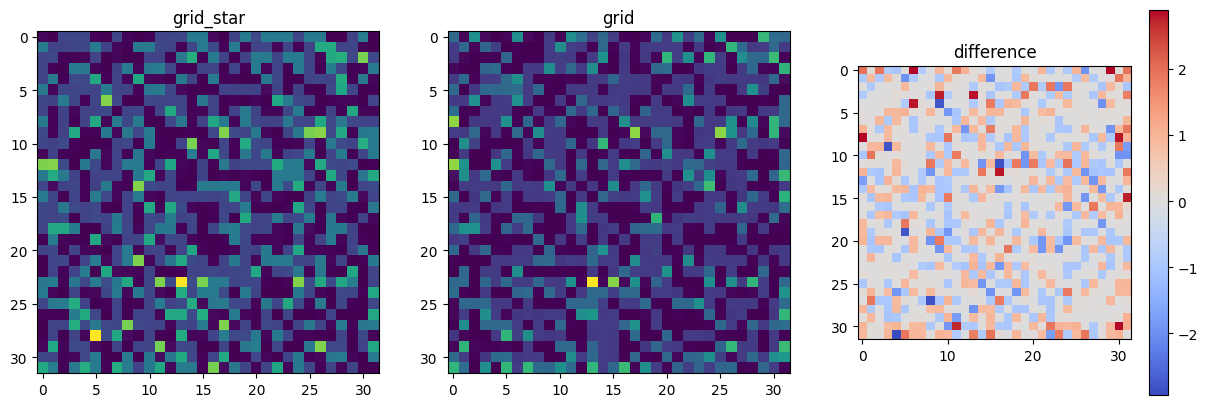

In [84]:
grid = cic_ma(params["pos"], params["weight"], grid_size, dx)

# define the desired change 
field = (grid - grid_star)

# plot side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(grid_star[grid_size // 2, :, :])
# set the title
plt.title('grid_star')
plt.subplot(1, 3, 2)
plt.imshow(grid[grid_size // 2, :, :])
# set the title
plt.title('grid')
plt.subplot(1, 3, 3)
plt.imshow(field[grid_size // 2, :, :], cmap='coolwarm')
# set the title
plt.title('difference')
# add colorbar
plt.colorbar()
plt.show()